In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import math
import copy

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
data = pd.read_csv('seattleWeather_1948-2017.csv')
data.head(5)

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


# Initial Data Cleaning

In [4]:
data.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [5]:
data[(data.RAIN != True) & (data.RAIN!=False)]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [6]:
data = data[(data.RAIN == True) | (data.RAIN==False)]

In [7]:
labelencoder = LabelEncoder()
data['RAIN'] = labelencoder.fit_transform(data['RAIN'])

In [8]:
data['MONTH'] = pd.DatetimeIndex(data['DATE']).month
data['DAY'] = pd.DatetimeIndex(data['DATE']).day
data.head()

,DATE,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
0,1948-01-01,0.47,51,42,1,1,1
1,1948-01-02,0.59,45,36,1,1,2
2,1948-01-03,0.42,45,35,1,1,3
3,1948-01-04,0.31,45,34,1,1,4
4,1948-01-05,0.17,45,32,1,1,5


# Preliminary Data Exploration

In [9]:
data.corr()

,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
PRCP,1.000000,-0.226736,-0.064365,0.515160,0.014918,-0.001339
TMAX,-0.226736,1.000000,0.860675,-0.389241,0.154972,0.001726
TMIN,-0.064365,0.860675,1.000000,-0.139905,0.222504,0.003190
RAIN,0.515160,-0.389241,-0.139905,1.000000,-0.046046,-0.003148
MONTH,0.014918,0.154972,0.222504,-0.046046,1.000000,0.009639
DAY,-0.001339,0.001726,0.003190,-0.003148,0.009639,1.000000


None of these variable seems to have any correlation since all of the covariance is less 0.5

In [10]:
rain = data[data.RAIN == True]
norain = data[data.RAIN == False]

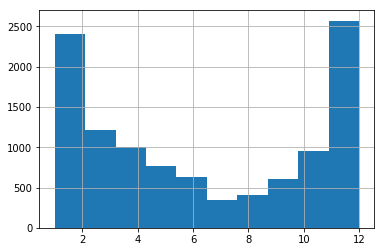

In [11]:
rain['MONTH'].hist()

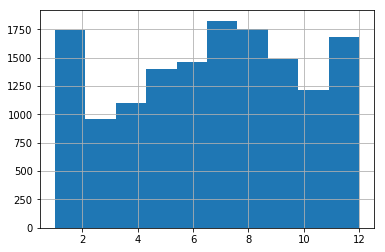

In [12]:
norain['MONTH'].hist()

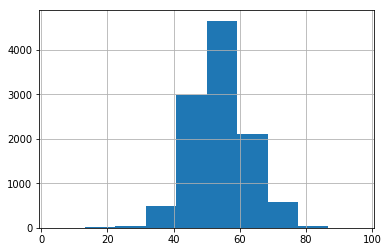

In [13]:
rain['TMAX'].hist()

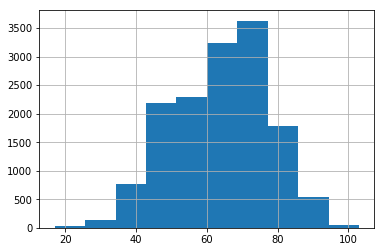

In [14]:
norain['TMAX'].hist()

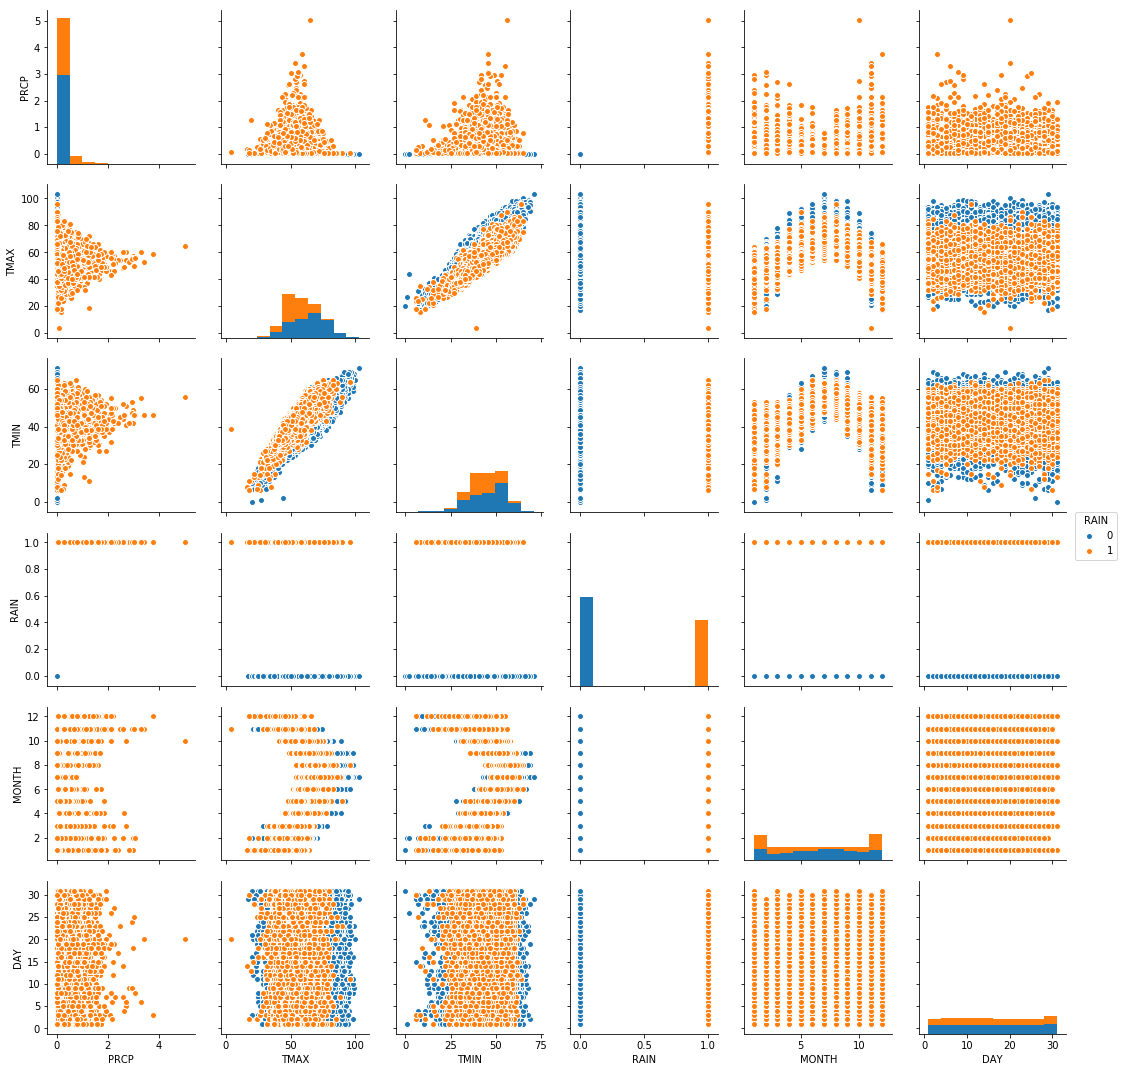

In [15]:
sns.pairplot(data, hue = 'RAIN')

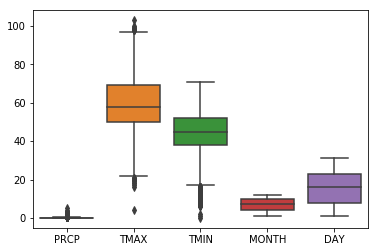

In [16]:
sns.boxplot(data=data[['PRCP','TMAX','TMIN','MONTH','DAY']])

There are some outliers in the graph, let see if we can take out the outliers by estimating the range of variable based on the box plots

In [17]:
dataN = data.copy()
dataN=dataN.drop(dataN[dataN['TMIN']<17 ].index)
dataN=dataN.drop(dataN[(dataN['TMAX']>97.5) | (dataN['TMAX']< 21.5)].index)
dataN=dataN.drop(dataN[(dataN['PRCP']>0.25) | (dataN['PRCP']< -0.15) ].index)

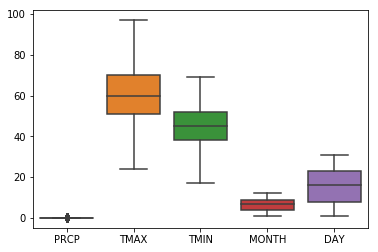

In [18]:
sns.boxplot(data=dataN[['PRCP','TMAX','TMIN','MONTH','DAY']])

We seem to have taken out of the outliers. We have also did some cleaning with the dataset as well.

# Cleaning

In [19]:
X = dataN[['PRCP','TMAX','TMIN','MONTH','DAY']].copy()
y = dataN['RAIN'].copy()

I did not use the dataN because I tried that out and it give a lower accuracy score, the original set of data with outliers seem to perform better with the models

# Transformation & Split

In [20]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.25, random_state = 5)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.25, random_state=5)

In [21]:
# len(ytest[ytest == 1]) /len(ytest)

In [22]:
# len(ytest[ytest == 0]) / len(ytest)

# Analyze
    False Positive is type II error, where the hypothesis is false but we fail to reject it.
    False Negative is type I error, where the hypothesis is true but we reject it.
    The common norm is that type I is worse than type II.

## SVM

array([0, 0, 0, ..., 0, 0, 0])

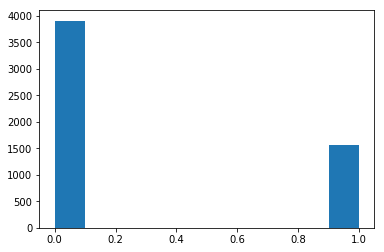

In [23]:
svc = SVC()
svc.fit(Xtrain,ytrain)
ypredS = svc.predict(Xtest)
plt.hist(ypredS)
ypredS

In [24]:
metrics.accuracy_score(ytest,ypredS)

0.7467568061392289

In [25]:
metrics.confusion_matrix(ytest,ypredS)
# TruePositive FalsePositive
# FalseNegative TrueNegative

array([[3073,  550],
       [ 836, 1014]])

In [26]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredS) / len(ytest), cmap='Blues', annot=True)

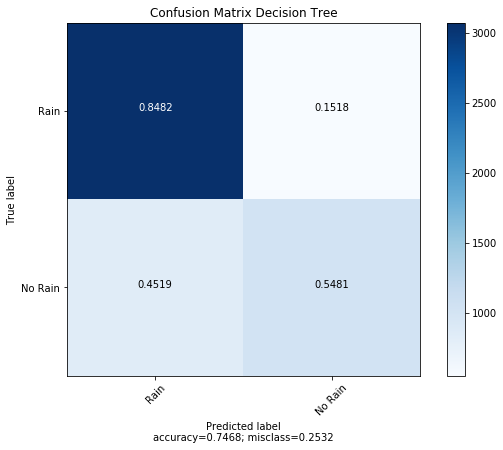

In [27]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest, ypredS),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [28]:
metrics.roc_auc_score(ytest,ypredS)

0.6981501070488099

In [29]:
svc = SVC()
svc.fit(XScaletrain,yscaletrain)
ypredscale = svc.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

0.9990864242645715

In [30]:
metrics.roc_auc_score(yscaletest,ypredscale)

0.9986486486486487

In [31]:
metrics.confusion_matrix(yscaletest,ypredscale)

array([[3623,    0],
       [   5, 1845]])

In [32]:
# sns.heatmap(metrics.confusion_matrix(yscaletest, ypredscale) / len(ytest), cmap='Blues', annot=True)

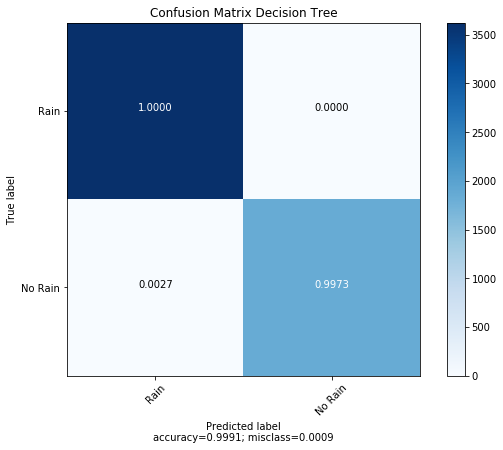

In [33]:
plot_confusion_matrix(cm = metrics.confusion_matrix(yscaletest, ypredscale),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

Scaling seem to improve the the accuracy

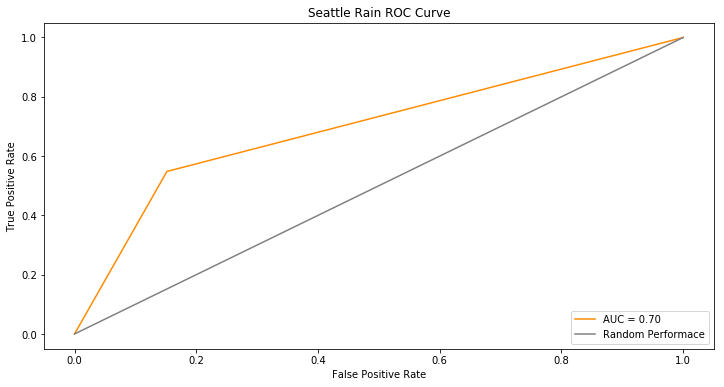

In [34]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredS)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

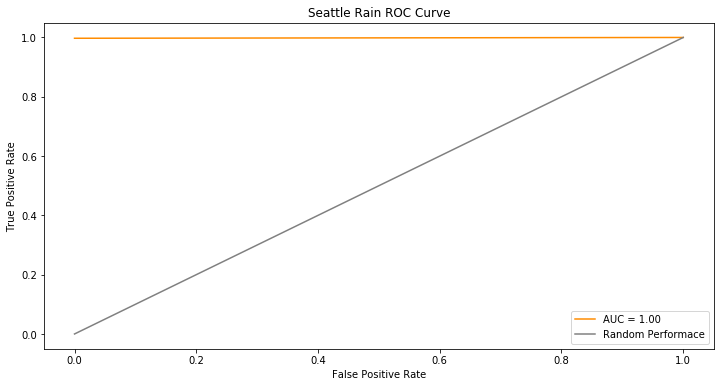

In [35]:
fpr, tpr, threshold = metrics.roc_curve(yscaletest, ypredscale)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

Scaling helps improve the performance of the test

## Logistic regression

(array([4051.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1422.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

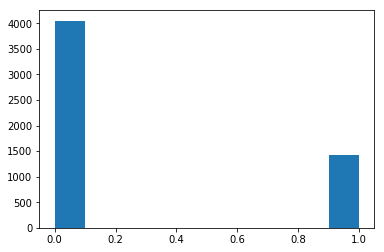

In [36]:
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)
plt.hist(ypredL)

In [37]:
metrics.accuracy_score(ytest,ypredL)

0.9148547414580669

In [38]:
metrics.confusion_matrix(ytest,ypredL)
# TruePositive FalsePositive
# FalseNegative TrueNegative

array([[3604,   19],
       [ 447, 1403]])

In [39]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredL) / len(ytest), cmap='Blues', annot=True)

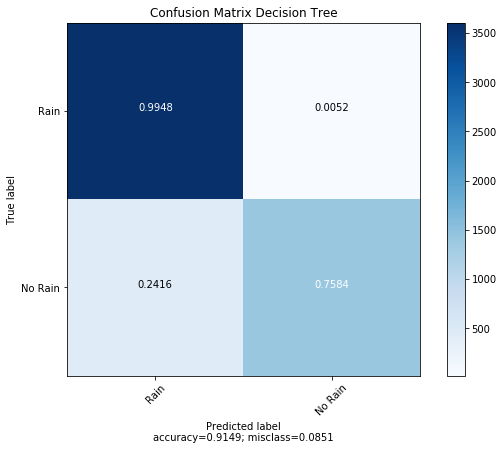

In [40]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredL),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [41]:
metrics.roc_auc_score(ytest,ypredL)

0.8765670528380989

In [42]:
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
ypredscale = lr.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

0.9989037091174858

In [43]:
metrics.roc_auc_score(yscaletest,ypredscale)

0.9983783783783784

In [44]:
metrics.confusion_matrix(yscaletest,ypredscale)

array([[3623,    0],
       [   6, 1844]])

In [45]:
# sns.heatmap(metrics.confusion_matrix(yscaletest, ypredscale) / len(ytest), cmap='Blues', annot=True)

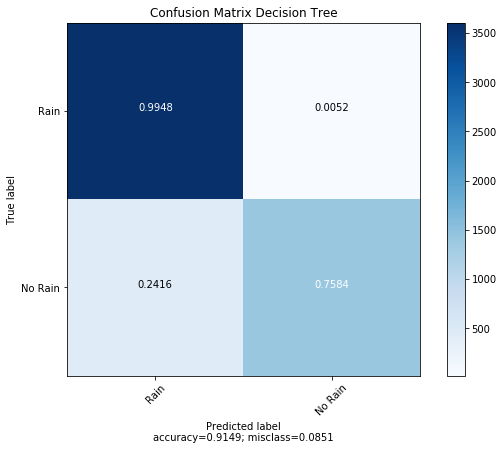

In [46]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredL),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

Scaling does help a bit but not a ton

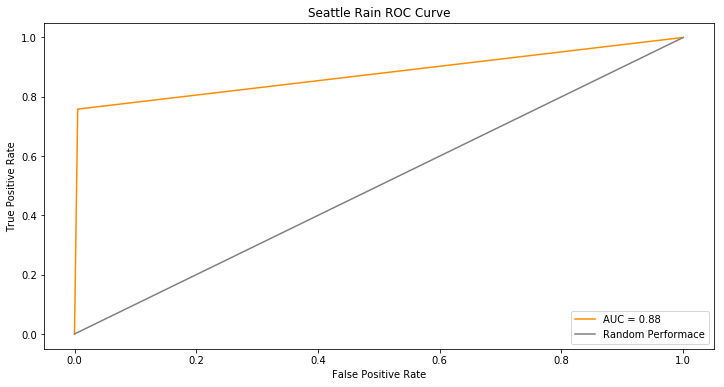

In [47]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredL)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

## Naive Bayes

(array([3623.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1850.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

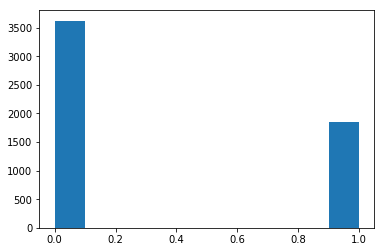

In [48]:
naive = GaussianNB()
naive.fit(Xtrain,ytrain)
ypredB = naive.predict(Xtest)
plt.hist(ypredB)

In [49]:
metrics.accuracy_score(ytest,ypredB)

1.0

In [50]:
metrics.confusion_matrix(ytest,ypredB)

array([[3623,    0],
       [   0, 1850]])

In [51]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredB) / len(ytest), cmap='Blues', annot=True)

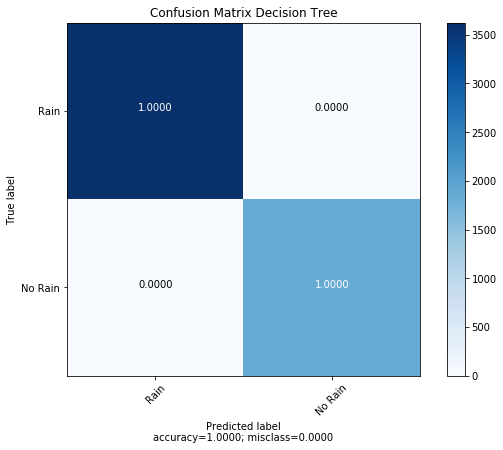

In [52]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredB),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [53]:
metrics.roc_auc_score(ytest,ypredB)

1.0

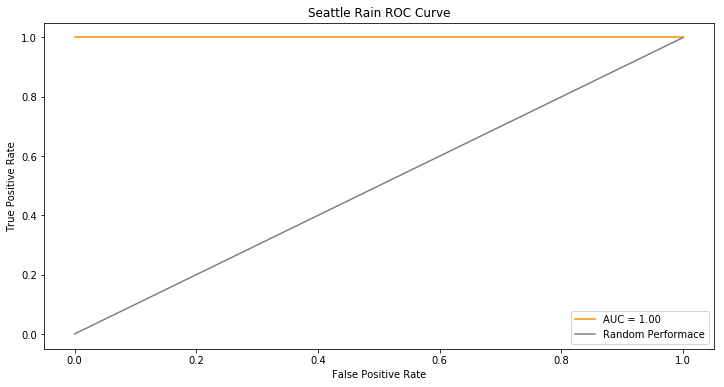

In [54]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredB)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

In [55]:
naive = GaussianNB()
naive.fit(XScaletrain,yscaletrain)
ypredscale = naive.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

1.0

Scaling does not impact the performance

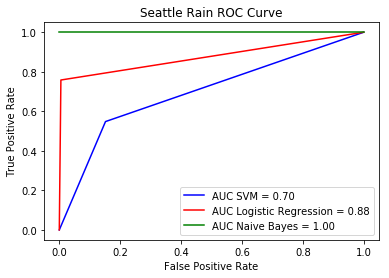

In [56]:
ypred = [ypredS,ypredL,ypredB]
test = ['SVM','Logistic Regression', 'Naive Bayes']
colors = ['blue','red','green']
for i in range(1, 4):
    fpr, tpr, threshold = metrics.roc_curve(ytest, ypred[i-1])
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i-1], label = 'AUC '+test[i-1]+' = %0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Seattle Rain ROC Curve')
    plt.legend(loc="lower right")

# We can see that the precipitation may impact the prediction of rain since it has a high corelation. Therefore, we would try dropping this parameter to see how it model perform

In [57]:
newdata = dataN.drop(['PRCP'], axis=1)
newdata.head()

,DATE,TMAX,TMIN,RAIN,MONTH,DAY
4,1948-01-05,45,32,1,1,5
7,1948-01-08,48,35,1,1,8
8,1948-01-09,50,31,1,1,9
10,1948-01-11,42,32,1,1,11
11,1948-01-12,41,26,0,1,12


In [58]:
X = newdata[['TMAX','TMIN','MONTH','DAY']]
y = newdata['RAIN']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.25, random_state=5)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.25, random_state=5)

## Naive Bayes

In [59]:
#without scaling
naive2 = GaussianNB()
naive2.fit(Xtrain,ytrain)
ypredN = naive2.predict(Xtest)

In [60]:
metrics.accuracy_score(ytest,ypredN)

0.6552165174492965

In [61]:
metrics.roc_auc_score(ytest,ypredN)

0.6390605068220304

In [62]:
#with scaling
naive2 = GaussianNB()
naive2.fit(XScaletrain,yscaletrain)
yscalepredN = naive2.predict(XScaletest)

In [63]:
metrics.accuracy_score(yscaletest,yscalepredN)

0.6552165174492965

In [64]:
metrics.roc_auc_score(yscaletest,yscalepredN)

0.6390605068220304

## Logistic Regression

In [65]:
#without scaling
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)

In [66]:
metrics.accuracy_score(ytest,ypredL)

0.7474876667275717

In [67]:
metrics.roc_auc_score(ytest,ypredL)

0.6990989250359937

In [68]:
#with scaling
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
yscalepredL = lr.predict(XScaletest)

In [69]:
metrics.accuracy_score(yscaletest,yscalepredL)

0.747304951580486

In [70]:
metrics.roc_auc_score(yscaletest,yscalepredL)

0.6986963916718265

## SVM

In [71]:
# without scaling
svm = SVC()
svm.fit(Xtrain,ytrain)
ypredS = svm.predict(Xtest)

In [72]:
metrics.accuracy_score(ytest,ypredS)

0.7379864790791156

In [73]:
metrics.roc_auc_score(ytest,ypredS)

0.686764291202602

In [74]:
#with scaling
svm = SVC()
svm.fit(XScaletrain,yscaletrain)
yscalepredS = svm.predict(XScaletest)

In [75]:
metrics.accuracy_score(yscaletest,yscalepredS)

0.755709848346428

In [76]:
metrics.roc_auc_score(yscaletest,yscalepredS)

0.7054415110666836

## Decision Tree

In [77]:
from sklearn.tree import DecisionTreeClassifier
# without scaling
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(Xtrain,ytrain)
ypredT = model_tree.predict(Xtest)

In [78]:
metrics.accuracy_score(ytest,ypredT)

0.740179060844144

In [79]:
# with scaling 
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(XScaletrain,yscaletrain)
yscalepredT = model_tree.predict(XScaletest)
metrics.accuracy_score(yscaletest,yscalepredT)

0.740179060844144

## Note: Scaling does not really help in this situation and once we drop precipitation, we can see that the model perform worse since precipitation, in this case, directly related to rain
Next step: try PCA to standardize the data to see whether the models have better performances. Also maybe try KMeans to see if it can predict the clustering 

In [80]:
from sklearn.decomposition import PCA
pca = PCA()
X = pca.fit_transform(X)
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.25,random_state=5)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.25, random_state=5)

In [81]:
# logistic Regression
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)

In [82]:
metrics.accuracy_score(ytest,ypredL)

0.7471222364334004

In [83]:
# Support vector machine
svm = SVC()
svm.fit(Xtrain,ytrain)
ypredS = svm.predict(Xtest)

In [84]:
metrics.accuracy_score(ytest,ypredS)

0.7379864790791156

## PCA does not seem to help in term of increasing the accuracy of the predictive model

In [85]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=5)
kmeans.fit(Xtrain,ytrain)
ypred = kmeans.predict(Xtest)

In [86]:
metrics.accuracy_score(ytest,ypred)

0.36999817284852915

## Kmeans perform horribly, this is probably because it is not supervised.
Next step, try undersampling to get a balance data set between rain and not-rain

In [87]:
rain = len(newdata[newdata['RAIN'] == 1])

In [88]:
rainIndices = newdata[newdata['RAIN'] == 0].index
random_indices = np.random.choice(rainIndices,rain, replace=False)

In [89]:
norain = newdata[newdata['RAIN'] == 1].index
under_sample_indices = np.concatenate([norain,random_indices])

In [90]:
under_sample = newdata.loc[under_sample_indices]

In [91]:
under_sample.groupby('RAIN').count()

,DATE,TMAX,TMIN,MONTH,DAY
RAIN,,,,,
0,7324,7324,7324,7324,7324
1,7324,7324,7324,7324,7324


In [92]:
X = under_sample[['TMAX','TMIN','MONTH','DAY']]
y = under_sample['RAIN']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.25, random_state=5)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.25, random_state=5)

In [93]:
# SVC
svm = SVC()
svm.fit(XScaletrain,yscaletrain)
ypredS = svm.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredS)

0.7512288367012562

In [94]:
print(metrics.classification_report(yscaletest,ypredS,target_names = ['Rain', 'No Rain']))

             precision    recall  f1-score   support

       Rain       0.81      0.66      0.73      1836
    No Rain       0.71      0.84      0.77      1826

avg / total       0.76      0.75      0.75      3662



In [95]:
svm = SVC()
svm.fit(Xtrain,ytrain)
ypredS = svm.predict(Xtest)
metrics.accuracy_score(ytest,ypredS)

0.7255598033861278

In [96]:
# Logistic regression
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)
metrics.accuracy_score(ytest,ypredL)

0.7348443473511742

In [97]:
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
ypredL = lr.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredL)

0.7342981977061714

In [98]:
print(metrics.classification_report(yscaletest,ypredL,target_names = ['Rain', 'No Rain']))

             precision    recall  f1-score   support

       Rain       0.76      0.69      0.72      1836
    No Rain       0.71      0.78      0.74      1826

avg / total       0.74      0.73      0.73      3662



In [99]:
# Decision Tree
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(Xtrain,ytrain)
ypredT = model_tree.predict(Xtest)
metrics.accuracy_score(ytest,ypredT)

0.7310212998361552

In [100]:
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(XScaletrain,yscaletrain)
ypredT = model_tree.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredT)

0.7310212998361552

In [101]:
print(metrics.classification_report(yscaletest,ypredT,target_names = ['Rain', 'No Rain']))

             precision    recall  f1-score   support

       Rain       0.76      0.68      0.72      1836
    No Rain       0.71      0.78      0.74      1826

avg / total       0.73      0.73      0.73      3662



## Final words: without precipitation, highest score we have for prediction is 74%, which are from logistic regression and decision tree after we scale the data and underperform it to get a more balance data set.

Grid search approach (what is optimizing for) , have each individual category vote on the decision, focus on the sample that predicted incorrectly, see if there is something that make it predict incorrectly.

______________________________________________________________________________________________________________________
# Midterm review

## Looking at data that has been predicted wrong to see if there is any helpful information.
I will use Logistic Regression prediction, the original data set without scaling or undervalue since these two methods did not improve the performance of this model

### Logistic Regression

In [102]:
# X = newdata[['TMAX','TMIN','MONTH','DAY']]
# y = newdata['RAIN']
test,train = train_test_split(newdata[['TMAX','TMIN','MONTH','DAY','RAIN']],test_size=0.25, random_state=5)
lr = LogisticRegression()
lr.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypred = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])

In [103]:
metrics.accuracy_score(test['RAIN'],ypred)

0.7484924163976366

In [104]:
test['RAINPred'] = [x for x in ypred]
test.head()

,TMAX,TMIN,MONTH,DAY,RAIN,RAINPred
20215,57,38,5,7,0,0
16865,49,36,3,5,0,0
22735,51,37,3,31,0,0
6796,69,56,8,10,0,0
12684,76,55,9,23,0,0


In [105]:
icPred = test[test.RAIN!=test.RAINPred]
icPred.head()

,TMAX,TMIN,MONTH,DAY,RAIN,RAINPred
21137,48,35,11,14,1,0
13846,27,21,11,28,0,1
15049,49,35,3,15,1,0
20791,47,40,12,3,0,1
20973,61,50,6,3,0,1


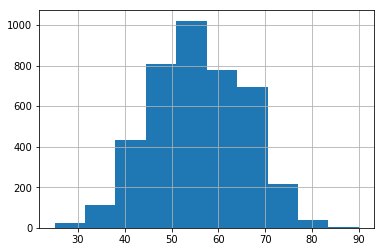

In [106]:
icPred.TMAX.hist()

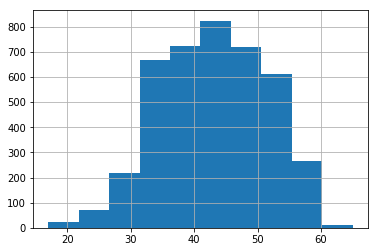

In [107]:
icPred.TMIN.hist()

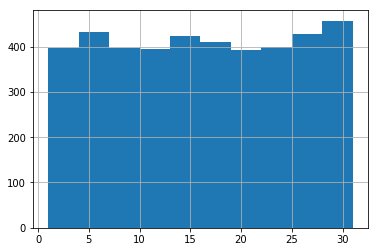

In [108]:
icPred.DAY.hist()

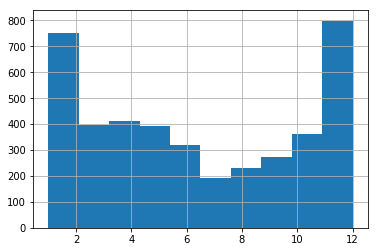

In [109]:
icPred.MONTH.hist()

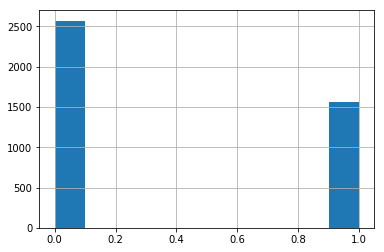

In [110]:
icPred.RAINPred.hist()

It seems like it predicts 0's wrong often than 1's and the prediction based on month seems to not correct. I will look at the right prediction to see if we see any similar trend.

In [111]:
cPred = test[test.RAIN == test.RAINPred]
cPred.head()

,TMAX,TMIN,MONTH,DAY,RAIN,RAINPred
20215,57,38,5,7,0,0
16865,49,36,3,5,0,0
22735,51,37,3,31,0,0
6796,69,56,8,10,0,0
12684,76,55,9,23,0,0


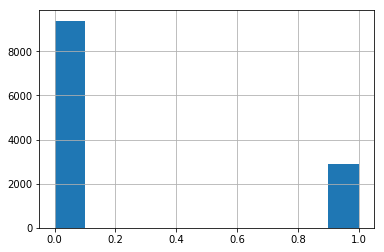

In [112]:
cPred.RAINPred.hist()

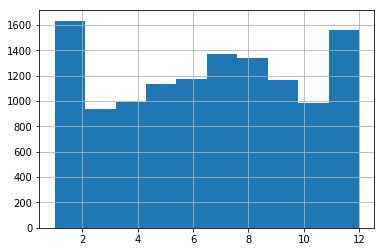

In [113]:
cPred.MONTH.hist()

In [114]:
len(cPred[cPred.MONTH == 1])

783

In [115]:
len(cPred[cPred.MONTH == 12])

790

In [116]:
len(icPred[icPred.MONTH == 1])

429

In [117]:
len(icPred[icPred.MONTH == 12])

431

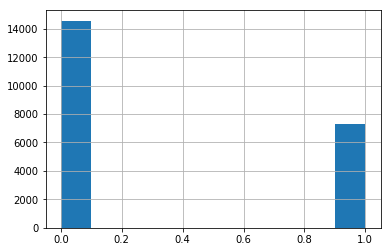

In [118]:
newdata.RAIN.hist()

As we can see there is significantly more day that there isn't rain than there is rain (and they say Seattle rain the whole year, what a lie, lol), let try underperform statistics to see what we can see

In [119]:
undersampledata = under_sample[['TMAX','TMIN','MONTH','DAY','RAIN']]
test,train = train_test_split(undersampledata,test_size=0.25, random_state=5)
lr = LogisticRegression()
lr.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypred = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])
test['RAINPred'] = [x for x in ypred]
icPred = test[test.RAIN!=test.RAINPred]
cPred = test[test.RAIN == test.RAINPred]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [120]:
print(metrics.classification_report(test['RAIN'],ypred))

             precision    recall  f1-score   support

          0       0.76      0.70      0.73      5488
          1       0.72      0.78      0.75      5498

avg / total       0.74      0.74      0.74     10986



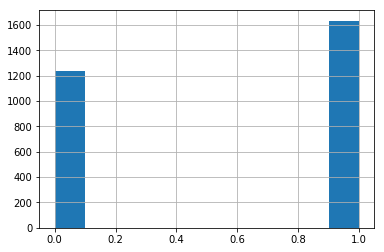

In [121]:
icPred.RAINPred.hist()

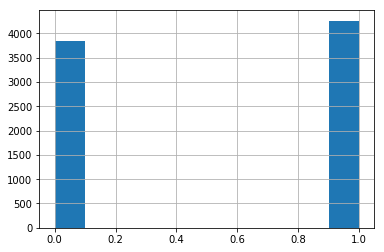

In [122]:
cPred.RAINPred.hist()

Different from the previous sample, after underperfome, 1 is actually predict more than 0, however, the gap of the number of days predicted RAIN is not significant more than the number of days predicted no rain like before underperfome. Similarly with the correct prediction, it seems to be a balance split for the number of days that predicted correctly whether it would rain or not.

### Decision Tree

In [123]:
test,train = train_test_split(newdata[['TMAX','TMIN','MONTH','DAY','RAIN']],test_size=0.25, random_state=5)
lr = DecisionTreeClassifier()
lr.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypred = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])
test['RAINPred'] = [x for x in ypred]
icPredTree = test[test.RAIN!=test.RAINPred]
cPredTree = test[test.RAIN == test.RAINPred]

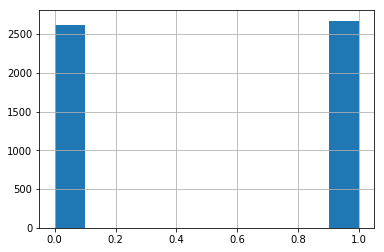

In [124]:
icPredTree.RAINPred.hist()

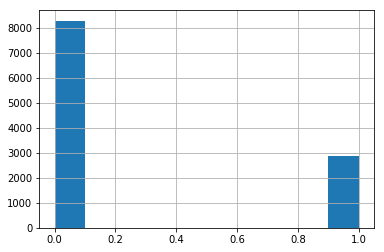

In [125]:
cPredTree.RAINPred.hist()

With decision tree, we can see that they predict non-rainy day more correct that rainy day. Similar to the previous case, it could be because of the skew dataset where there are more non-rainy day  than rainy day so we would try to fit underperform data in to see if it changes anything.

In [126]:
undersampledata = under_sample[['TMAX','TMIN','MONTH','DAY','RAIN']]
test,train = train_test_split(undersampledata,test_size=0.25, random_state=5)
lr = DecisionTreeClassifier()
lr.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypred = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])
test['RAINPred'] = [x for x in ypred]
icPredTree = test[test.RAIN!=test.RAINPred]
cPredTree = test[test.RAIN == test.RAINPred]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [127]:
print(metrics.classification_report(test['RAIN'],ypred))

             precision    recall  f1-score   support

          0       0.67      0.67      0.67      5488
          1       0.67      0.67      0.67      5498

avg / total       0.67      0.67      0.67     10986



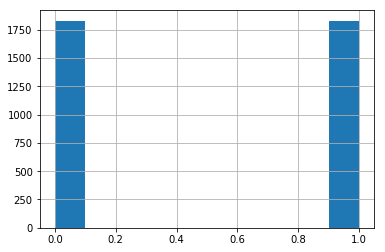

In [128]:
icPredTree.RAINPred.hist()

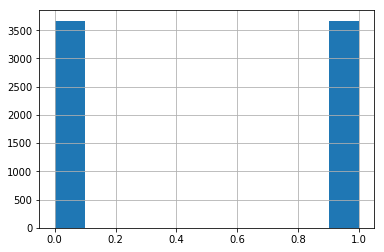

In [129]:
cPredTree.RAINPred.hist()

After underperform, it looks like decision tree prediction is somewhat more balance, but it does not help us much since we do not know what the tree do well at.

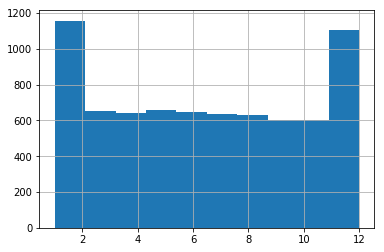

In [130]:
cPredTree.MONTH.hist()

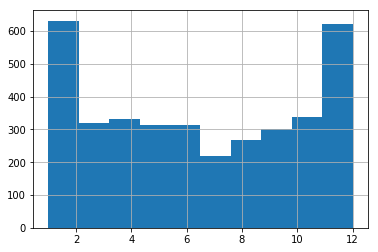

In [131]:
icPredTree.MONTH.hist()

These graphs do not really add in much information since it shows that there is an equal chance that the model would predict rain or not rain on any given month.

### SVM

In [132]:
test,train = train_test_split(newdata[['TMAX','TMIN','MONTH','DAY','RAIN']],test_size=0.25, random_state=5)
lr = SVC()
lr.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypred = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])
test['RAINPred'] = [x for x in ypred]
icPredSVM = test[test.RAIN!=test.RAINPred]
cPredSVM = test[test.RAIN == test.RAINPred]

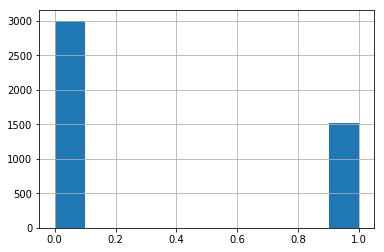

In [133]:
icPredSVM.RAINPred.hist()

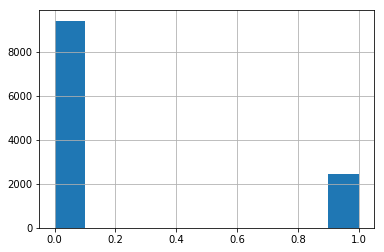

In [134]:
cPredSVM.RAINPred.hist()

We can see that Support Vector Machine predict more non-rainy day correctly than rainy day and also more non-rainly day incorrectly than rainly day on a skew dataset. Once more time, we would use the underperforming dataset.

In [135]:
undersampledata = under_sample[['TMAX','TMIN','MONTH','DAY','RAIN']]
test,train = train_test_split(undersampledata,test_size=0.25, random_state=5)
svm = SVC()
svm.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypred = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])
test['RAINPred'] = [x for x in ypred]
icPredSVM = test[test.RAIN!=test.RAINPred]
cPredSVM = test[test.RAIN == test.RAINPred]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [136]:
print(metrics.classification_report(test['RAIN'],ypred))

             precision    recall  f1-score   support

          0       0.65      0.89      0.75      5488
          1       0.82      0.53      0.64      5498

avg / total       0.74      0.71      0.70     10986



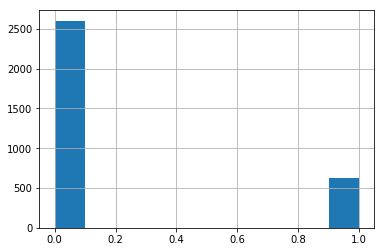

In [137]:
icPredSVM.RAINPred.hist()

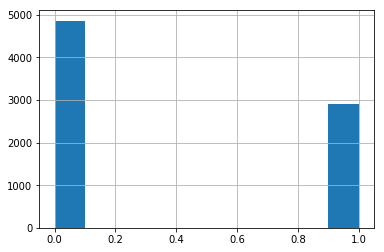

In [138]:
cPredSVM.RAINPred.hist()

This is a similar behavior that we have seen with the DecisionTree model. Let see if there are any records that all of the model predict correct or incorrect!

In [139]:
undersampledata = under_sample[['TMAX','TMIN','MONTH','DAY','RAIN']]
test,train = train_test_split(undersampledata,test_size=0.25, random_state=5)
svm = SVC()
lr = LogisticRegression()
tree = DecisionTreeClassifier()
svm.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
lr.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
tree.fit(train[['TMAX','TMIN','MONTH','DAY']],train['RAIN'])
ypredSVM = svm.predict(test[['TMAX','TMIN','MONTH','DAY']])
ypredLR = lr.predict(test[['TMAX','TMIN','MONTH','DAY']])
ypredTree = tree.predict(test[['TMAX','TMIN','MONTH','DAY']])
test['RAINPredSVM'] = [x for x in ypredSVM]
test['RAINPredLR'] = [x for x in ypredLR]
test['RAINPredTree'] = [x for x in ypredTree]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [140]:
test.head()

,TMAX,TMIN,MONTH,DAY,RAIN,RAINPredSVM,RAINPredLR,RAINPredTree
11218,64,43,9,18,0,0,0,0
19014,46,37,1,22,1,1,1,1
15590,71,55,9,7,1,0,0,1
11916,69,56,8,16,0,1,1,1
17220,58,42,2,23,0,1,0,1


In [141]:
# now we look at the data where all the predictions are incorrect
interesting = test[(test.RAINPredSVM == test.RAINPredLR) &(test.RAINPredLR == test.RAINPredTree) & (test.RAINPredLR!= test.RAIN)]
len(interesting)/len(test)

0.13926815947569635

In [142]:
falsenegative = interesting[interesting.RAIN==1]
len(falsenegative)

638

In [143]:
truenegative = interesting[interesting.RAIN==0]
len(truenegative)

892

We can see that there are significant more true negative that false negative, which means that there are more prediction that there would be no rain but it actually rains rather than the other way around. 

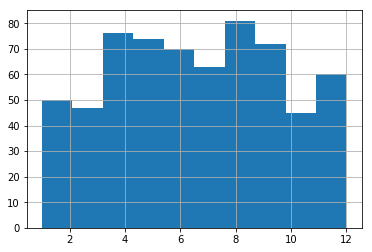

In [144]:
falsenegative.MONTH.hist()

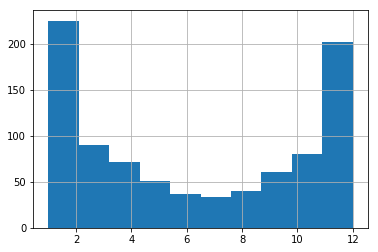

In [145]:
truenegative.MONTH.hist()

So, it seems like if the month is withhin April to September, there are more false negative prediction, whic means if the prediction of all data set is 0 in these month, it could be 1 instead. Maybe we can use these information for the voting system.

## Using GridSearchCV to search for the most influencial paramenter
I will try GridSearchCV to see which parameter has the most influence on the dataset and maybe that would help me with increasing the accuracy score of my predictions. I will try it on DecicionTree, Logistic Regression and SVM. Parameters in this case are the factors deciding how the model behave; in example for Decision Tree, they could be gini and entrophy, for Logistic Regression and Support Vector Machine are linear, polynomial, sigmoid and etc.

In [146]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [147]:
# We would use the data that are underperform because this data is less skew and it seems like the model perform more 'fairly' with this dataset
XTrain, Xtest, ytrain, ytest = train_test_split(undersampledata[['MONTH','DAY','TMAX','TMIN']],undersampledata['RAIN'],test_size=0.25, random_state=5)

In [148]:
print(len(ytest[ytest==1]),len(ytest[ytest==0]))

1826 1836


In [149]:
criteria = ["gini", "entropy"]      #criteria to be tested
min_sample_split_range = [2,10, 20] #min sample split to be tested
max_depth_range = [None, 2, 5, 10]  #max depth to be tested
min_samples_leaf_range = [1, 5, 10] #min samples in the leaf to be tested
min_leaf_nodes_range = [None, 5, 10, 20]    #min leaf nodes to be tested

param_grid = {"criterion": criteria,
              "min_samples_split": min_sample_split_range,
              "max_depth": max_depth_range,
              "min_samples_leaf": min_samples_leaf_range,
              "max_leaf_nodes": min_leaf_nodes_range
                }

grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                    param_grid=param_grid, 
                    cv = 5, 
                    scoring='accuracy', 
                    refit=True)     #setting grid with estimator
   
grid.fit(undersampledata[['MONTH','DAY','TMAX','TMIN']],undersampledata['RAIN'])      #fitting data

print("Accuracy of the tuned model: %.4f" %grid.best_score_)
print(grid.best_params_)

Accuracy of the tuned model: 0.7340
{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'gini'}


This imply that gini is a better hyperparameter than entropy on the training set and it would give us around 73% accuracy, which is what we have been seeing in the performance of models when we try to predict this dataset. 

In [150]:
tree_model = DecisionTreeClassifier(max_leaf_nodes= 20, min_samples_split= 2, max_depth= None, min_samples_leaf= 1, criterion = 'entropy')
tree_model.fit(Xtrain,ytrain)
ytreepred = tree_model.predict(Xtest)
metrics.accuracy_score(ytest,ytreepred)

0.4991807755324959

In [151]:
print(metrics.classification_report(ytest,ytreepred))

             precision    recall  f1-score   support

          0       0.50      0.98      0.66      1836
          1       0.45      0.02      0.04      1826

avg / total       0.47      0.50      0.35      3662



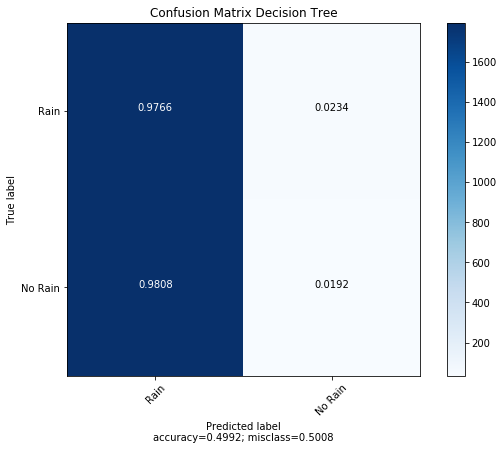

In [152]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ytreepred),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [153]:
print(len(ytreepred[ytreepred==1]),len(ytreepred[ytreepred==0]))

78 3584


#### Conclusion for this model:
We can see that with the best parameter that GridSearch gives, our accuracy score is extremely low and the model mostly predict 0 comparing to 1, creating a lot of false negative. 

## Now we would try GridSearch on SVM to see what we would get

In [167]:
kernel_types = ["linear", "poly",'rbf','sigmoid']     #types of kernels to be tested
C_range = [0.01, 0.1, 1, 10, 100, 1000]                 #range of C to be tested
degree_range = [1, 2, 3, 4, 5]                       #degrees to be tested

param_grid = {"kernel": kernel_types,
              "C": C_range,
              "degree": degree_range,
              }         #setting grid of parameters

grid = GridSearchCV(estimator = SVC(), 
                    param_grid = param_grid, 
                    cv = 5, 
                    scoring = 'accuracy', 
                    refit = True)   #setting grid with estimator

svm_model = make_pipeline(preprocessing.StandardScaler(), grid)     #creating preprocessing
svm_model.fit(undersampledata[['MONTH','DAY','TMAX','TMIN']],undersampledata['RAIN'])       #fitting data

print("Accuracy of the tuned model: %.4f" %grid.best_score_)
print(grid.best_params_)

Accuracy of the tuned model: 0.7492
{'kernel': 'rbf', 'degree': 1, 'C': 10}


We can see that SVM with kernel types rbf, degree 1, and C = 10 gives us the best accuracy score of almost 75%. We will train the model again to see if it can reach to this accuracy.

In [176]:
svmgrid = SVC(kernel='rbf',degree=1,C = 10)
svmgrid.fit(Xtrain,ytrain)
ypredsvm = svmgrid.predict(Xtest)
metrics.accuracy_score(ytest,ypredsvm)

0.5013653741125068

In [177]:
print(metrics.classification_report(ytest,ypredsvm))

             precision    recall  f1-score   support

          0       0.50      1.00      0.67      1836
          1       0.00      0.00      0.00      1826

avg / total       0.25      0.50      0.33      3662



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [171]:
metrics.confusion_matrix(ytest,ypredsvm)

array([[1836,    0],
       [1826,    0]])

In [178]:
len(ypredsvm[ypredsvm==1])

0

We can see that once we use the grid model, we have a bad accuracy score, which is only 50%. It worth noticing that the model only predict 0. 

## Last but not least, let's try GridSearch on Logistic Regression 

In [174]:
param_grid = {"penalty": ['l1','l2'],
              "C": np.logspace(0, 4, 10)}         #setting grid of parameters

grid = GridSearchCV(estimator = LogisticRegression(), 
                    param_grid = param_grid, 
                    cv = 5, 
                    scoring = 'accuracy', 
                    refit = True)   #setting grid with estimator

svm_model = make_pipeline(preprocessing.StandardScaler(), grid)     #creating preprocessing
svm_model.fit(undersampledata[['MONTH','DAY','TMAX','TMIN']],undersampledata['RAIN'])       #fitting data

print("Accuracy of the tuned model: %.4f" %grid.best_score_)
print(grid.best_params_)

Accuracy of the tuned model: 0.7368
{'penalty': 'l1', 'C': 1.0}


The gridsearch show that the model perform the best with penalty of l1 with C-degree of 1, giving us the accuracy score of aroudn 74%, which is not much different from other models we have been testing out. Let try to fit the data to see what we would get:

In [179]:
lrgrid = LogisticRegression(penalty='l1', C=1) 
lrgrid.fit(Xtrain,ytrain)
ypredlr = lrgrid.predict(Xtest)
metrics.accuracy_score(ytest,ypredlr)

0.5420535226652102

In [180]:
print(metrics.classification_report(ytest,ypredsvm))

             precision    recall  f1-score   support

          0       0.50      1.00      0.67      1836
          1       0.00      0.00      0.00      1826

avg / total       0.25      0.50      0.33      3662



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [181]:
metrics.confusion_matrix(ytest,ypredsvm)

array([[1836,    0],
       [1826,    0]])

In [182]:
len(ypredsvm[ypredsvm==1])

0

We can see that once we use the grid model, we have a bad accuracy score, which is only 54%. It worth noticing that the model only predict 0. 

# Construction a vote system:

In [162]:
class Vote:
    def __init__(self):
        self.tree = DecisionTreeClassifier()
        self.lr = LogisticRegression()
        self.svm = SVC()
    
    def fit(self,X,y):
        self.tree.fit(X,y)
        self.lr.fit(X,y)
        self.svm.fit(X,y)
    
    def predict(self,X):
        ypredtree = self.tree.predict(X)
        ypredlr = self.lr.predict(X)
        ypredsvm = self.svm.predict(X)
        res = [0]*len(X)
        for i in range(0,len(X)):
            if ypredtree[i]+ypredlr[i]+ypredsvm[i]>=2:
                res[i]= 1
            elif ypredtree[i]+ypredlr[i]+ypredsvm[i]==0:
                if X.iloc[i]['MONTH'] <= 9 & X.iloc[i]['MONTH'] >=4:
                    res[i] = 1
                else:
                    res[i] = 0
            else:
                res[i] = 0
        return res

In [157]:
XTrain, Xtest, ytrain, ytest = train_test_split(undersampledata[['MONTH','DAY','TMAX','TMIN']],undersampledata['RAIN'],test_size=0.25, random_state=5)
vote = Vote()
vote.fit(XTrain,ytrain)

In [163]:
ypred = vote.predict(Xtest)
metrics.accuracy_score(ytest,ypred)

0.72801747678864

## Conclusion:
Unfortunately,the accuracy do not imporved much :( It would be helpful to get the percentage of humidity since that may have more impact on the prediction of whether it would rain or not.